# Spacegroup determination: comparing spglib vs neural network based on the diffraction intensity in spherical harmonics (DISH) descriptor

Author: Angelo Ziletti (angelo.ziletti@gmail.com; ziletti@fhi-berlin.mpg.de)

In [1]:
from ai4materials.dataprocessing.preprocessing import load_dataset_from_file
from ai4materials.wrappers import load_descriptor
from ai4materials.utils.utils_config import set_configs
from ai4materials.utils.utils_config import setup_logger
from ai4materials.dataprocessing.preprocessing import load_dataset_from_file
from ai4materials.dataprocessing.preprocessing import prepare_dataset
from ai4materials.utils.utils_crystals import random_displace_atoms
from ai4materials.utils.utils_crystals import get_spacegroup, get_spacegroup_analyzer
from ai4materials.utils.utils_data_retrieval import read_ase_db
from ase.spacegroup import get_spacegroup as ase_get_spacegroup
from asap3.analysis.localstructure import RestrictedCNA
from asap3 import FullNeighborList
from asap3.analysis import CoordinationNumbers, FullCNA, PTM
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline  

main_folder = '/home/ziletti/Documents/calc_nomadml/rot_inv_3d/'
dataset_folder = os.path.abspath(os.path.normpath(os.path.join(main_folder, 'datasets')))
desc_folder = os.path.abspath(os.path.normpath(os.path.join(main_folder, 'desc_folder')))

configs = set_configs(main_folder=main_folder)
logger = setup_logger(configs, level='INFO', display_configs=False)
configs['io']['dataset_folder'] = dataset_folder
configs['io']['desc_folder'] = desc_folder

/home/ziletti/anaconda2/lib/python2.7/site-packages/pymatgen/__init__.py:87: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Loading prototype database and check the classification for pristine structures

In [ ]:
db_files_prototypes_basedir = '/home/ziletti/Documents/calc_nomadml/rot_inv_3d/db_ase/'

proto_names = ['A_cP1_221_a']

prototypes_basedir = '/home/ziletti/Documents/calc_nomadml/rot_inv_3d/prototypes_aflow_new'
ase_db_files = [os.path.join(db_files_prototypes_basedir, proto_name) + '.db' for proto_name in proto_names]

db_protos = zip(proto_names, ase_db_files)

In [ ]:
from ai4materials.utils.utils_data_retrieval import read_ase_db
from ai4materials.utils.utils_crystals import create_supercell
import random 

y_pred = []
for idx_db, db_proto in enumerate(db_protos):
    ase_atoms_list = read_ase_db(db_path=ase_db_files[idx_db])

In [ ]:
print(len(ase_atoms_list[0]))

## Polyhedral template matching

In [16]:
ase_db_dataset_dir = '/home/ziletti/Documents/calc_nomadml/rot_inv_3d/db_ase'

ase_db_pristine = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_pristine' + '.db')

ase_db_disp1 = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_displacement-1%' + '.db')
ase_db_disp2 = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_displacement-2%' + '.db')

ase_db_vac1 = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_vacancies-1%' + '.db')
ase_db_vac2 = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_vacancies-2%' + '.db')
ase_db_vac5 = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_vacancies-5%' + '.db')
ase_db_vac10 = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_vacancies-10%' + '.db')
ase_db_vac20 = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_vacancies-20%' + '.db')
ase_db_vac25 = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_vacancies-25%' + '.db')
ase_db_vac50 = os.path.join(ase_db_dataset_dir, 'hcp-sc-fcc-diam-bcc_vacancies-50%' + '.db')

#ase_atoms_pristine = read_ase_db(db_path=ase_db_pristine)
#ase_atoms_disp1 = read_ase_db(db_path=ase_db_disp1)
#ase_atoms_disp2 = read_ase_db(db_path=ase_db_disp2)
#ase_atoms_vac1 = read_ase_db(db_path=ase_db_vac1)
#ase_atoms_vac2 = read_ase_db(db_path=ase_db_vac2)
ase_atoms_vac5 = read_ase_db(db_path=ase_db_vac5)
#ase_atoms_vac10 = read_ase_db(db_path=ase_db_vac10)
#ase_atoms_vac20 = read_ase_db(db_path=ase_db_vac20)

#ase_atoms_vac25 = read_ase_db(db_path=ase_db_vac25)
#ase_atoms_vac50 = read_ase_db(db_path=ase_db_vac50)

## Vacancies

In [17]:
#ptm.keys()
#classes = ['None', 'FCC', 'HCP', 'BCC', 'Ic', 'SC']
classes = ['None', '225', '194', '229', 'Ic', '221']
y_pred_ptm = []
y_true = []

for idx, atoms in enumerate(ase_atoms_vac5):
    if idx%1000 == 0: 
        print(idx)
    
    if str(atoms.info['target']) == '227':
        pass
    else:
        atoms=atoms*(2, 2, 2)
        #ptm = PTM(atoms=atoms)
        #atom_class_ptm = [classes[item] for item in ptm['structure']]
        #data = Counter(atom_class)
        #print(data.most_common(2))
        #y_pred_ptm.append(data.most_common(1)[0][0])
        atom_class_true = [str(atoms.info['target'])]*len(atoms)
        y_true.extend(atom_class_true)
        #y_pred_ptm.extend(atom_class_ptm)

print(len(y_true))
print(Counter(y_true), Counter(y_pred_ptm))


0
1000
2000
3000
4000
5000
6000
7000
8000
7117880
(Counter({'194': 4461680, '229': 892800, '221': 885600, '225': 877800}), Counter())


In [14]:
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred_ptm)))
cnf_matrix = confusion_matrix(y_true, y_pred_ptm)
np.set_printoptions(precision=2)

Accuracy: 0.126298413419


/home/ziletti/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


Normalized confusion matrix
[[1.10e-01 3.68e-01 1.67e-02 1.37e-02 1.72e-03 4.89e-01]
 [1.11e-01 4.04e-01 1.86e-02 2.21e-02 3.01e-04 4.44e-01]
 [1.37e-01 3.46e-01 2.14e-02 2.54e-02 1.18e-03 4.69e-01]
 [1.52e-01 3.91e-01 2.17e-02 3.14e-02 2.43e-03 4.02e-01]
 [     nan      nan      nan      nan      nan      nan]
 [     nan      nan      nan      nan      nan      nan]]


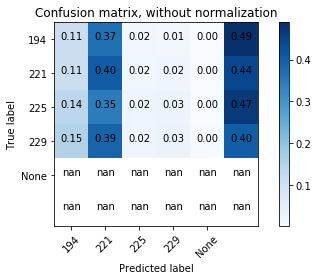

In [15]:
#print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes=['194', '221', '225', '229', 'None'],
                      normalize=True, title='Confusion matrix, without normalization')

## Displacements

In [ ]:
#ptm.keys()
#classes = ['None', 'FCC', 'HCP', 'BCC', 'Ic', 'SC']
classes = ['None', '225', '194', '229', 'Ic', '221']
y_pred_ptm = []
y_true = []

for idx, atoms in enumerate(ase_atoms_disp1):
    if idx%1000 == 0: 
        print(idx)
    
    if str(atoms.info['target']) == '227':
        pass
    else:
        atoms=atoms*(2, 2, 2)
        ptm = PTM(atoms=atoms)
        atom_class_ptm = [classes[item] for item in ptm['structure']]
        #data = Counter(atom_class)
        #print(data.most_common(2))
        #y_pred_ptm.append(data.most_common(1)[0][0])
        atom_class_true = [str(atoms.info['target'])]*len(atoms)
        y_true.extend(atom_class_true)
        y_pred_ptm.extend(atom_class_ptm)

print(Counter(y_true), Counter(y_pred_ptm))


In [ ]:
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred_ptm)))
cnf_matrix = confusion_matrix(y_true, y_pred_ptm)
np.set_printoptions(precision=2)

In [ ]:
#print(cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes=['194', '221', '225', '229', 'None'],
                      normalize=True, title='Confusion matrix, without normalization')

## Classification results spglib

In [ ]:
y_pred = []
y_true = []
ase_atoms_list = ase_atoms_list[:5]

y_true = y_true + [221]*len(ase_atoms_list)

for idx, structure in enumerate(ase_atoms_list):
    y_pred.append(ase_get_spacegroup(structure, symprec=1e-3).no)

In [ ]:
accuracy_score(y_true, y_pred)

In [ ]:
Counter(y_true), Counter(y_pred)

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
cnf_matrix

## Supercell creation

In [ ]:
y_pred = []
y_pred_sc1 = []
y_pred_sc2 = []
y_pred_sc3 = []

ase_atoms_list_supercell = []

for idx, structure in enumerate(ase_atoms_list):
    #supercell =  create_supercell(structure, create_replicas_by='nb_atoms', 
    #                              target_nb_atoms=128, optimal_supercell=True)
    
    #supercell =  random_displace_atoms(structure, displacement_scaled=1e-12, 
    #                                   create_replicas_by='nb_atoms', 
    #                                   noise_distribution='uniform_scaled', 
    #                                   target_nb_atoms=128,
    #                                   optimal_supercell=True)

    supercell =  random_displace_atoms(structure, displacement_scaled=0.01, 
                                       create_replicas_by='nb_atoms', 
                                       noise_distribution='uniform_scaled', 
                                       target_nb_atoms=128,
                                       optimal_supercell=True)
        
    alpha = random.random() * 360.0
    structure.rotate(alpha, 'x', rotate_cell=True, center='COU')

    beta = random.random() * 360.0
    structure.rotate(beta, 'y', rotate_cell=True, center='COU')

    gamma = random.random() * 360.0
    structure.rotate(gamma, 'z', rotate_cell=True, center='COU')
    
    ase_atoms_list_supercell.append(supercell)
    
    get_spacegroup(supercell, symprec=[1e-1, 1e-2, 1e-3], angle_tolerance=5.0)

    y_pred_sc1.append(supercell.info['spacegroup_nb_0.1'])
    y_pred_sc2.append(supercell.info['spacegroup_nb_0.01'])
    y_pred_sc3.append(supercell.info['spacegroup_nb_0.001'])


In [ ]:
for structure in ase_atoms_list_supercell:
    print(structure.info.keys())

In [ ]:
y_true = [221]*len(ase_atoms_list)
#accuracy_score(y_pred, y_pred_sc)
accuracy_score(y_true, y_pred_sc1), accuracy_score(y_true, y_pred_sc2), accuracy_score(y_true, y_pred_sc3)

In [ ]:
Counter(y_true), Counter(y_pred_sc1), Counter(y_pred_sc2), Counter(y_pred_sc3)

In [ ]:
from ase.visualize import view
idx=1
# change idx if you want to visualize another structure 
# idx=0 visualizes the first structure in the list
# Note: 0<=idx<len(ase_atoms_list)
view(ase_atoms_list_supercell[idx]*(1, 1, 1), viewer='x3d')
#view(ase_atoms_list[idx]*(3, 3, 3), viewer='x3d')

In [ ]:
atoms = ase_atoms_list_supercell[0]
coord_num = CoordinationNumbers(atoms, rCut=4.)
print(coord_num)

In [ ]:
print(coord_num)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
bins = np.arange(-0.5, max(coord_num) + 1)
ax.hist(coord_num, bins)
ax.set_title('Coordination number')
ax.set_xlabel("Number of nearest neighbors")
ax.set_ylabel("Number of atoms")
plt.show()

In [ ]:
r_scale_list = np.linspace(0.5, 2.0, 20)
avg_neihbour = []
for r_scale in r_scale_list:
    coord_num = CoordinationNumbers(atoms=atoms, rCut=r_scale * 4.0)
    avg_neihbour.append(np.average(coord_num))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(r_scale_list, avg_neihbour)
ax.set_xlabel("r_scale")
ax.set_ylabel("Average of nearest neighbors")
ax.set_title("Coordination Numbers")
plt.show()

In [ ]:
classes = ['None', 'FCC', 'HCP', 'BCC', 'Ic', 'SC']

y_pred_ptm = [classes[item] for item in ptm['structure']]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.hist(ptm['structure'], range(0, 7))
# ax1.set_yscale('symlog')
ax1.set_xticks([x + .5 for x in range(6)])
ax1.set_xticklabels(['None', 'FCC', 'HCP', 'BCC', 'Ic', 'SC'])
ax1.set_title('Structure')
ax2.hist(ptm['scale'])
# ax2.set_yscale('symlog')
ax2.set_title('The average distance scale')
plt.show()